In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

# Data cleaning

In [6]:
#read data with decimals as dot
df = pd.read_csv('../../data/amazon_search_hedonic.csv', sep = ";", decimal = ".")

In [73]:
df['helpful'].value_counts()

0.0       64827
1.0       21064
2.0        9820
3.0        5864
4.0        3789
          ...  
439.0         1
4718.0        1
380.0         1
520.0         1
127.0         1
Name: helpful, Length: 371, dtype: int64

In [7]:
#remove duplicates and empty variables
df1 = len(df)
print(df1)
df = df.drop_duplicates(subset = ['review_title', 'review', 'date', 'name', 'profile_url'])
df2 = len(df)
print(df2)
print('Removed', df1 - df2, 'duplicates')
df = df[df['country'] == 'the United States']
df3 = len(df)
print('Removed', df3 - df2, 'non USA reviews')
print(df3)
df = df[df['review'] != '']
df4 = len(df)
print('Removed', df4 - df3, 'empty reviews')
#remove reviews with na
df = df.dropna(subset = ['review'])
df5 = len(df)
print('Removed', df5 - df4, 'na reviews')


166392
133986
Removed 32406 duplicates
Removed -9481 non USA reviews
124505
Removed 0 empty reviews
Removed -2926 na reviews


In [8]:
# correct mistake in encoding numerical data
df['helpful'] = df['helpful'].str.replace(',', '')

df['helpful'] = pd.to_numeric(df['helpful'])

In [9]:
#impute 0 for missing helpful votes
df['helpful'] = df['helpful'].fillna(0)

In [10]:
#1.5 IQR outlier for helpful

Q1 = df['helpful'].quantile(0.25)
Q3 = df['helpful'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
print(df['helpful'].quantile(0.95))
df['helpful'].quantile(0.75) + 1.5*IQR

#(df['helpful'] > 5).sum()

2.0
12.0


5.0

In [13]:
#add id so can reorder into original order for concatting and merging
df['id'] = range(0, len(df))

In [14]:
#merge with category data
def remove_last_digit(string):
    return re.sub(r'\d+$', '', string)

df['asin_url_clean'] = df['asin_url'].apply(remove_last_digit)
links_data = pd.read_csv(f"../../gen/input/amazon_links_per_category.csv", delimiter = ";")
#remove duplicates for links_data product_link
links_data = links_data.drop_duplicates(subset = ['product_link'])
df = pd.merge(df, links_data, left_on = 'asin_url_clean', right_on = 'product_link', how = 'left')

In [18]:
sum(df['id'] != range(0, len(df)))

0

In [15]:
df.columns

Index(['asin_url', 'brand', 'model', 'link', 'product_title', 'name_x',
       'rating', 'review_title', 'country', 'date', 'specs', 'first_spec',
       'review', 'helpful', 'picture', 'verified', 'profile', 'video',
       'scrape_date', 'profile_url', 'id', 'asin_url_clean', 'name_y', 'asin',
       'product_link', 'page_link', 'category'],
      dtype='object')

In [19]:
#drop columns
df = df.drop(columns = ['brand', 'model', 'first_spec', 'asin_url_clean', 'product_link', 'page_link', 'name_y'])

In [20]:
#summary
print(df['category'].value_counts())

mascara                 12200
microwave oven          10868
vacuum cleaner          10723
Digital Photo Frames    10657
razor                   10593
computer adapter        10092
lipstick                 9924
electric toothbrush      9711
party dress              9434
dvd_player               9275
printer                  9212
smartphone               8890
Name: category, dtype: int64


# Add variables

In [21]:
import ast
def count_photos(pics):
    if pics == 'no':
        return 0
    else:
        return len(ast.literal_eval(pics))

df['n_pictures'] = df['picture'].apply(count_photos)

In [22]:
#length of review
df['review_len'] = df['review'].str.len()

In [23]:
df['date'] = pd.to_datetime(df['date'], format='%B %d, %Y')

In [24]:
df['days_diff'] = (pd.to_datetime(df['scrape_date']) - df['date']).dt.days

In [25]:
#print the number of observations per category, and the number of unique products, and the number of non=nan profile values
df_descriptives = df.groupby('category').agg({'category': 'size',
                                  'asin': 'nunique',
                                  'profile': lambda x: sum(~x.isna()),
                                  'picture': lambda x: sum(x != 'no'),
                                  'n_pictures': 'mean',
                                  'review_len' : 'mean',
                                  'helpful' : 'mean',
                                    'rating' : 'mean',
                                    #add average date
                                    'days_diff' : 'mean'

                                  })
#df_descriptives.columns = ['n_obs', 'n_products', 'n_profiles', 'n_pictures', 'photos_per_review', 'helpful_mean', 'rating_mean']
df_descriptives['profile'] = df_descriptives['profile']/df_descriptives['category']*100
df_descriptives['picture'] = df_descriptives['picture']/df_descriptives['category']*100

#change order of category
df_descriptives = df_descriptives.reindex(df['category'].unique())
#add average at bottom
df_descriptives.loc['average'] = df_descriptives.mean()
#sum at the bottom, except for the average row
df_descriptives.loc['sum'] = df_descriptives.iloc[:-1, :].sum()
#round values to 3 decimals
df_descriptives = df_descriptives.round(2)
#to percentage
df_descriptives['profile'] = df_descriptives['profile'].astype(str) + '%'
df_descriptives['picture'] = df_descriptives['picture'].astype(str) + '%'
print(df_descriptives)
#save to excel
df_descriptives.to_excel('../../gen/output/amazon_descriptives.xlsx')

                       category    asin  profile  picture  n_pictures  \
category                                                                
dvd_player              9275.00   146.0   14.91%    4.18%        0.10   
Digital Photo Frames   10657.00   206.0   21.11%   12.59%        0.31   
smartphone              8890.00   338.0   18.08%    7.63%        0.19   
computer adapter       10092.00   246.0   18.25%    5.13%        0.10   
printer                 9212.00   177.0   15.61%    5.91%        0.11   
electric toothbrush     9711.00   165.0    21.3%    8.62%        0.21   
mascara                12200.00   142.0   17.39%     5.8%        0.10   
lipstick                9924.00   156.0   20.61%    9.89%        0.17   
party dress             9434.00   182.0    23.2%   31.42%        0.52   
microwave oven         10868.00   170.0   14.24%    9.09%        0.17   
vacuum cleaner         10723.00   224.0   15.15%    8.48%        0.20   
razor                  10593.00   140.0   19.14%   

In [26]:
df.columns

Index(['asin_url', 'link', 'product_title', 'name_x', 'rating', 'review_title',
       'country', 'date', 'specs', 'review', 'helpful', 'picture', 'verified',
       'profile', 'video', 'scrape_date', 'profile_url', 'id', 'asin',
       'category', 'n_pictures', 'review_len', 'days_diff'],
      dtype='object')

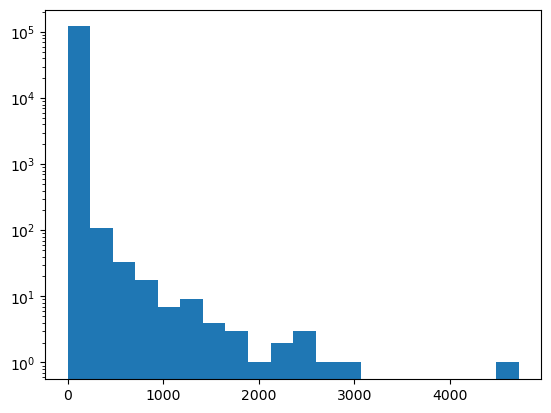

In [27]:
#show histogram of helpful votes with log10 y scale

plt.hist(df['helpful'], bins = 20)
plt.yscale('log')

In [17]:
#proportion of reviews with at least 1 helpful vote
len(df[df['helpful'] > 0]) / len(df)

0.46679113991725546

# review cleaning

In [28]:
#remove punctuation from review
print(df['review'][0])
df['review_clean'] = df['review'].str.replace('[^\w\s]','')
print(df['review_clean'][0])
#lowercase everything
df['review_clean'] = df['review_clean'].str.lower()
print(df['review_clean'][0])
#remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['review_clean'] = df['review_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df['review_clean'][0])
#stemming
from nltk.stem import PorterStemmer
porter = PorterStemmer()
df['review_clean'] = df['review_clean'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))
print(df['review_clean'][0])
#tokenize review
#from nltk.tokenize import word_tokenize
#df['review_clean'] = df['review_clean'].apply(word_tokenize)
#print(df['review_clean'][0])


This brand DVD player works great.  Will be buying several more for MBR, guest room, and craft room.


C:\Users\janva\AppData\Local\Temp\ipykernel_32624\2016550727.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_clean'] = df['review'].str.replace('[^\w\s]','')


This brand DVD player works great  Will be buying several more for MBR guest room and craft room
this brand dvd player works great  will be buying several more for mbr guest room and craft room
brand dvd player works great buying several mbr guest room craft room
brand dvd player work great buy sever mbr guest room craft room


In [29]:
df['category'].unique()

array(['dvd_player', 'Digital Photo Frames', 'smartphone',
       'computer adapter', 'printer', 'electric toothbrush', 'mascara',
       'lipstick', 'party dress', 'microwave oven', 'vacuum cleaner',
       'razor'], dtype=object)

In [30]:
hedonic = 3*["Hedonic"] + 3*['Utilitarian'] + 3*["Hedonic"] + 3*['Utilitarian']
search = 6*["Search"] + 6*["Experience"]

In [31]:
categories = pd.DataFrame({'category': df['category'].unique(), 'hedonic_utilitarian': hedonic, 'search_experience': search})
categories

,category,hedonic_utilitarian,search_experience
0,dvd_player,Hedonic,Search
1,Digital Photo Frames,Hedonic,Search
2,smartphone,Hedonic,Search
3,computer adapter,Utilitarian,Search
4,printer,Utilitarian,Search
5,electric toothbrush,Utilitarian,Search
6,mascara,Hedonic,Experience
7,lipstick,Hedonic,Experience
8,party dress,Hedonic,Experience
9,microwave oven,Utilitarian,Experience


In [32]:
#merge with data
df = pd.merge(df, categories, on = 'category', how = 'left')

In [33]:
sum(df['id'] != range(0, len(df)))

0

In [34]:
#Replace underscore with space and capitalize every word in category
df['category'] = df['category'].str.replace('_', ' ').str.title()

In [35]:
#save to csv
df.to_csv('../../gen/input/amazon_search_hedonic_clean.csv', sep = ";", index = False)

# merge with api data

In [2]:
df = pd.read_csv('../../gen/input/amazon_search_hedonic_clean.csv', sep = ";")

In [6]:
len(df[df['helpful'] > 1000]['helpful'])

30

In [38]:
api_data = pd.read_csv('../../gen/input/api_info.csv', sep = ";")
api_data

,date,price_new,price_used,rating,reviews,asin,oos_new,oos_used,listed_since
0,2019-01-03,59.99,NaN,NaN,NaN,B07LFYCXKW,6,56,4287360
1,2019-02-09,NaN,NaN,5.0,1.0,B07LFYCXKW,6,56,4287360
2,2019-02-14,78.99,NaN,NaN,NaN,B07LFYCXKW,6,56,4287360
3,2019-02-17,NaN,NaN,NaN,NaN,B07LFYCXKW,6,56,4287360
4,2019-02-18,78.99,NaN,NaN,NaN,B07LFYCXKW,6,56,4287360
...,...,...,...,...,...,...,...,...,...
1026174,2024-04-15,705.95,NaN,NaN,NaN,B07NJ2T8H2,11,6,4466880
1026175,2024-04-16,878.90,297.770,NaN,NaN,B07NJ2T8H2,11,6,4466880
1026176,2024-04-20,NaN,360.885,4.0,45.0,B07NJ2T8H2,11,6,4466880
1026177,2024-04-21,NaN,281.230,NaN,NaN,B07NJ2T8H2,11,6,4466880


In [9]:
#check if api_data has datetimeindex
asin_data.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            584, 585, 586, 587, 588, 589, 590, 591, 592, 593],
           dtype='int64', length=594)

In [39]:
#make empty dataframe with same column names
api_data_clean = pd.DataFrame(columns = api_data.columns)

#loop over asins
for asin in df['asin'].unique():
    #get the data for the asin
    asin_data = api_data[api_data['asin'] == asin]
    #set datetime index
    asin_data.index = pd.to_datetime(asin_data['date'])
    asin_data = asin_data.interpolate(method='time')
    asin_data = asin_data.fillna(method='bfill')
    asin_data = asin_data.fillna(method='ffill')
    #add to the dataframe
    api_data_clean = api_data_clean.append(asin_data)
    

C:\Users\janva\AppData\Local\Temp\ipykernel_32624\429068465.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api_data_clean = api_data_clean.append(asin_data)
C:\Users\janva\AppData\Local\Temp\ipykernel_32624\429068465.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api_data_clean = api_data_clean.append(asin_data)
C:\Users\janva\AppData\Local\Temp\ipykernel_32624\429068465.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api_data_clean = api_data_clean.append(asin_data)
C:\Users\janva\AppData\Local\Temp\ipykernel_32624\429068465.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api_data_clean = api_data_clean.append(asi

In [44]:
#save api clean
api_data_clean.to_csv('../../gen/input/api_info_clean.csv', sep = ";")

In [5]:
#open api clean
api_data_clean = pd.read_csv('../../gen/input/api_info_clean.csv', sep = ";", index_col = 0)

In [6]:
api_data_clean

,date,price_new,price_used,rating,reviews,asin,oos_new,oos_used,listed_since
2019-01-03,2019-01-03,59.990000,73.46,5.000000,1.000000,B07LFYCXKW,6,56,4287360
2019-02-09,2019-02-09,76.728095,73.46,5.000000,1.000000,B07LFYCXKW,6,56,4287360
2019-02-14,2019-02-14,78.990000,73.46,4.967742,1.357143,B07LFYCXKW,6,56,4287360
2019-02-17,2019-02-17,78.990000,73.46,4.948387,1.571429,B07LFYCXKW,6,56,4287360
2019-02-18,2019-02-18,78.990000,73.46,4.941935,1.642857,B07LFYCXKW,6,56,4287360
...,...,...,...,...,...,...,...,...,...
2024-04-17,2024-04-17,749.000000,139.99,4.400000,8540.000000,B07DFM8BXZ,82,52,3898396
2024-04-19,2024-04-19,749.000000,139.99,4.400000,8539.000000,B07DFM8BXZ,82,52,3898396
2024-04-20,2024-04-20,749.000000,139.99,4.400000,8538.000000,B07DFM8BXZ,82,52,3898396
2024-04-22,2024-04-22,749.000000,139.99,4.400000,8539.000000,B07DFM8BXZ,82,52,3898396


In [36]:
def return_features(asin):
    df_agg = api_data_clean[api_data_clean['asin'] == asin][['price_new', 'rating']].agg(['mean', 'min', 'max', 'median'])
    reshaped_df = pd.DataFrame(df_agg.values.reshape(1, -1))
    reshaped_df.columns = [f'{col}_{idx}' for idx in df_agg.index for col in df_agg.columns]
    reshaped_df['asin'] = asin
    return reshaped_df

In [42]:
return_features('fdsaf').columns

Index(['price_new_mean', 'rating_mean', 'price_new_min', 'rating_min',
       'price_new_max', 'rating_max', 'price_new_median', 'rating_median',
       'asin'],
      dtype='object')

In [38]:
api_data_clean[api_data_clean['asin'] == "fdsaf"][['price_new', 'rating']].agg(['mean', 'min', 'max', 'median'])

,price_new,rating
mean,NaN,NaN
min,NaN,NaN
max,NaN,NaN
median,NaN,NaN


In [43]:
asin_info = pd.DataFrame(columns = ['price_new_mean', 'rating_mean', 'price_new_min', 'rating_min',
       'price_new_max', 'rating_max', 'price_new_median', 'rating_median',
       'asin'])
for asin in df['asin'].unique():
    asin_info = pd.concat([asin_info, return_features(asin)], axis = 0)

asin_info

,price_new_mean,rating_mean,price_new_min,rating_min,price_new_max,rating_max,price_new_median,rating_median,asin
0,72.379094,4.445254,52.99,4.2,89.990000,5.0,71.991111,4.447785,B07LFYCXKW
0,39.219527,4.132017,29.72,2.8,56.973333,5.0,38.928846,4.133333,B07Z7YMQYT
0,47.400000,4.549851,47.40,4.5,47.400000,4.6,47.400000,4.549254,B000FOVTD8
0,173.663333,3.088889,69.99,3.0,228.000000,3.1,198.000000,3.100000,B0002ARPEW
0,146.880557,4.144236,62.99,3.9,159.000000,5.0,148.400000,4.117701,B01M8HMK79
...,...,...,...,...,...,...,...,...,...
0,39.961867,4.863467,39.83,4.8,39.990000,5.0,39.980000,4.800000,B0CHHL5R3H
0,508.878889,4.088779,499.99,3.0,659.990000,5.0,499.990000,3.940541,B0CMHZNRH3
0,629.990000,4.433333,629.99,3.8,629.990000,5.0,629.990000,4.400000,B0CSFPBT78
0,72.383715,2.641189,59.99,2.0,89.990000,3.6,70.084340,2.503846,B0BB9S2HXN


In [46]:
asin_info.reset_index(drop = True, inplace = True)

In [47]:
asin_info

,price_new_mean,rating_mean,price_new_min,rating_min,price_new_max,rating_max,price_new_median,rating_median,asin
0,72.379094,4.445254,52.99,4.2,89.990000,5.0,71.991111,4.447785,B07LFYCXKW
1,39.219527,4.132017,29.72,2.8,56.973333,5.0,38.928846,4.133333,B07Z7YMQYT
2,47.400000,4.549851,47.40,4.5,47.400000,4.6,47.400000,4.549254,B000FOVTD8
3,173.663333,3.088889,69.99,3.0,228.000000,3.1,198.000000,3.100000,B0002ARPEW
4,146.880557,4.144236,62.99,3.9,159.000000,5.0,148.400000,4.117701,B01M8HMK79
...,...,...,...,...,...,...,...,...,...
2287,39.961867,4.863467,39.83,4.8,39.990000,5.0,39.980000,4.800000,B0CHHL5R3H
2288,508.878889,4.088779,499.99,3.0,659.990000,5.0,499.990000,3.940541,B0CMHZNRH3
2289,629.990000,4.433333,629.99,3.8,629.990000,5.0,629.990000,4.400000,B0CSFPBT78
2290,72.383715,2.641189,59.99,2.0,89.990000,3.6,70.084340,2.503846,B0BB9S2HXN


In [48]:
#merge asin_info
df = pd.merge(df, asin_info, on = 'asin', how = 'left')

In [56]:
#date to datetime
api_data_clean['date'] = pd.to_datetime(api_data_clean['date'])

In [55]:
api_data_clean

,date,price_rd,price_used,rating_rd,reviews_rd,asin,oos_new,oos_used,listed_since
2019-01-03,2019-01-03,59.990000,73.46,5.000000,1.000000,B07LFYCXKW,6,56,4287360
2019-02-09,2019-02-09,76.728095,73.46,5.000000,1.000000,B07LFYCXKW,6,56,4287360
2019-02-14,2019-02-14,78.990000,73.46,4.967742,1.357143,B07LFYCXKW,6,56,4287360
2019-02-17,2019-02-17,78.990000,73.46,4.948387,1.571429,B07LFYCXKW,6,56,4287360
2019-02-18,2019-02-18,78.990000,73.46,4.941935,1.642857,B07LFYCXKW,6,56,4287360
...,...,...,...,...,...,...,...,...,...
2024-04-17,2024-04-17,749.000000,139.99,4.400000,8540.000000,B07DFM8BXZ,82,52,3898396
2024-04-19,2024-04-19,749.000000,139.99,4.400000,8539.000000,B07DFM8BXZ,82,52,3898396
2024-04-20,2024-04-20,749.000000,139.99,4.400000,8538.000000,B07DFM8BXZ,82,52,3898396
2024-04-22,2024-04-22,749.000000,139.99,4.400000,8539.000000,B07DFM8BXZ,82,52,3898396


In [50]:
df['date'] = pd.to_datetime(df['date'])

In [51]:
df.columns

Index(['asin_url', 'link', 'product_title', 'name_x', 'rating', 'review_title',
       'country', 'date', 'specs', 'review', 'helpful', 'picture', 'verified',
       'profile', 'video', 'scrape_date', 'profile_url', 'id', 'asin',
       'category', 'n_pictures', 'review_len', 'days_diff', 'review_clean',
       'hedonic_utilitarian', 'search_experience', 'price_new_mean',
       'rating_mean', 'price_new_min', 'rating_min', 'price_new_max',
       'rating_max', 'price_new_median', 'rating_median'],
      dtype='object')

In [52]:
api_data_clean.columns

Index(['date', 'price_new', 'price_used', 'rating', 'reviews', 'asin',
       'oos_new', 'oos_used', 'listed_since'],
      dtype='object')

In [53]:
api_data_clean.rename({'price_new' : 'price_rd', 'rating' : 'rating_rd', 'reviews' : 'reviews_rd'}, axis = 1, inplace = True)

In [57]:
#merge df with api_data_clean on asin and nearest date
df_m = pd.merge_asof(df.sort_values('date'), api_data_clean.sort_values('date'), on = 'date', by = 'asin', direction = 'nearest')

In [59]:
df_m['id']

0           2377
1           1310
2           1328
3           1333
4           1288
           ...  
121574    121352
121575    120631
121576    120936
121577    120082
121578    117125
Name: id, Length: 121579, dtype: int64

In [60]:
df_m['scrape_date'] = pd.to_datetime(df_m['scrape_date'])

In [20]:
df_m['scrape_date']

0        2024-04-21 13:21:13
1        2024-04-21 13:21:17
2        2024-04-21 13:21:17
3        2024-04-21 13:21:05
4        2024-04-21 13:21:19
                 ...        
114973   2024-04-26 09:40:36
114974   2024-04-25 21:46:49
114975   2024-04-25 21:32:57
114976   2024-04-26 10:17:44
114977   2024-04-26 09:42:07
Name: scrape_date, Length: 114978, dtype: datetime64[ns]

In [11]:
api_data_clean.columns

Index(['date', 'price_rd', 'price_used', 'rating_rd', 'reviews_rd', 'asin',
       'oos_new', 'oos_used', 'listed_since'],
      dtype='object')

In [61]:
api_data_clean_sd = api_data_clean.drop(columns = ['price_used', 'oos_new', 'oos_used', 'listed_since'])

In [62]:
api_data_clean_sd.rename({'price_rd' : 'price_sd', 'rating_rd' : 'rating_sd', 'reviews_rd' : 'reviews_sd', 'date' : 'scrape_date'}, axis = 1, inplace = True)

In [63]:
df_m = pd.merge_asof(df_m.sort_values('scrape_date'), api_data_clean_sd.sort_values('scrape_date'), on = 'scrape_date', by = 'asin', direction = 'nearest')

In [65]:
df_m.columns

Index(['asin_url', 'link', 'product_title', 'name_x', 'rating', 'review_title',
       'country', 'date', 'specs', 'review', 'helpful', 'picture', 'verified',
       'profile', 'video', 'scrape_date', 'profile_url', 'id', 'asin',
       'category', 'n_pictures', 'review_len', 'days_diff', 'review_clean',
       'hedonic_utilitarian', 'search_experience', 'price_new_mean',
       'rating_mean', 'price_new_min', 'rating_min', 'price_new_max',
       'rating_max', 'price_new_median', 'rating_median', 'price_rd',
       'price_used', 'rating_rd', 'reviews_rd', 'oos_new', 'oos_used',
       'listed_since', 'price_sd', 'rating_sd', 'reviews_sd'],
      dtype='object')

In [64]:
#order df_m based on id
df_m = df_m.sort_values('id')

In [66]:
df_m['price_diff'] = df_m['price_sd'] - df_m['price_rd']
df_m['rating_diff'] = df_m['rating_sd'] - df_m['rating_rd']
df_m['reviews_diff'] = df_m['reviews_sd'] - df_m['reviews_rd']

(array([  107.,   223.,   137.,   107.,   135.,   199.,   231.,   278.,
          580.,   761., 11340.,  8081.,  6373.,  5788.,  4920.,  4609.,
         4103.,  3511.,  3198.,  2992.]),
 array([-200., -180., -160., -140., -120., -100.,  -80.,  -60.,  -40.,
         -20.,    0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,
         160.,  180.,  200.]),
 <BarContainer object of 20 artists>)

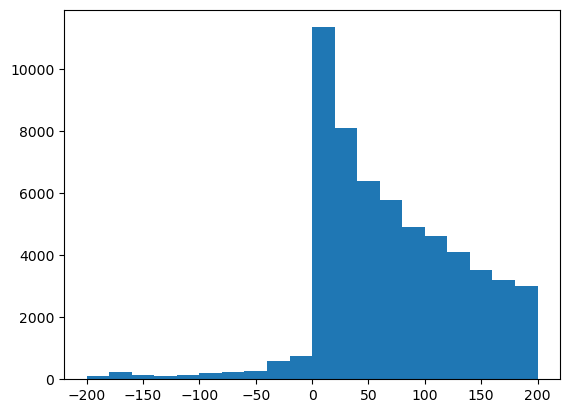

In [67]:
#show reviews_diff distribution, show x-asis from -200 to 200
plt.hist(df_m['reviews_diff'], bins = 20, range = (-200, 200))

(array([2.00000e+00, 1.00000e+00, 7.00000e+00, 1.00000e+00, 4.00000e+00,
        5.00000e+00, 5.20000e+01, 3.35000e+02, 9.55000e+02, 6.35700e+03,
        1.01804e+05, 2.92900e+03, 6.85000e+02, 5.16000e+02, 7.01000e+02,
        1.48000e+02, 7.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([-1264.60733333, -1141.42396667, -1018.2406    ,  -895.05723333,
         -771.87386667,  -648.6905    ,  -525.50713333,  -402.32376667,
         -279.1404    ,  -155.95703333,   -32.77366667,    90.4097    ,
          213.59306667,   336.77643333,   459.9598    ,   583.14316667,
          706.32653333,   829.5099    ,   952.69326667,  1075.87663333,
         1199.06      ]),
 <BarContainer object of 20 artists>)

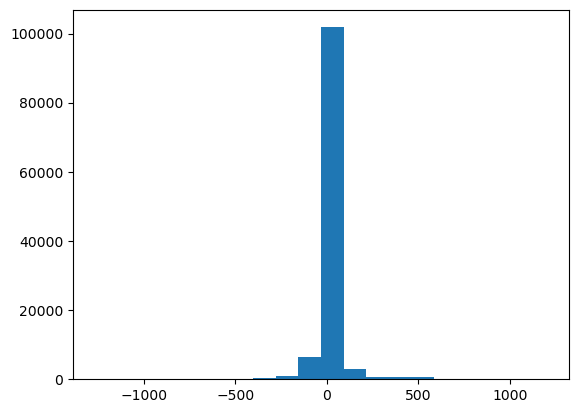

In [37]:
plt.hist(df_m['price_diff'], bins = 20)

In [27]:
df_m['review'].iloc[50000]

'One of my favorite Summer neutral colors for everyday wear!  Works well.'

In [68]:
#501 missing for price, 513 for rating and reviews
df_m.isna().sum()

asin_url                    0
link                        0
product_title               0
name_x                     16
rating                      0
review_title                0
country                     0
date                        0
specs                       0
review                      0
helpful                     0
picture                     0
verified                    0
profile                 99436
video                  119921
scrape_date                 0
profile_url                 0
id                          0
asin                        0
category                    0
n_pictures                  0
review_len                  0
days_diff                   0
review_clean              103
hedonic_utilitarian         0
search_experience           0
price_new_mean            501
rating_mean               513
price_new_min             501
rating_min                513
price_new_max             501
rating_max                513
price_new_median          501
rating_med

In [69]:
#fill in reviews na using mean on review date
df_m['price_rd'] = df_m['price_rd'].fillna(df_m['price_rd'].mean())
df_m['rating_rd'] = df_m['rating_rd'].fillna(df_m['rating_rd'].mean())
df_m['reviews_rd'] = df_m['reviews_rd'].fillna(df_m['reviews_rd'].mean())

#varaibles at scrape date
df_m['price_sd'] = df_m['price_sd'].fillna(df_m['price_sd'].mean())
df_m['rating_sd'] = df_m['rating_sd'].fillna(df_m['rating_sd'].mean())
df_m['reviews_sd'] = df_m['reviews_sd'].fillna(df_m['reviews_sd'].mean())

#difference
df_m['price_diff'] = df_m['price_diff'].fillna(df_m['price_diff'].mean())
df_m['rating_diff'] = df_m['rating_diff'].fillna(df_m['rating_diff'].mean())
df_m['reviews_diff'] = df_m['reviews_diff'].fillna(df_m['reviews_diff'].mean())

#fill in for price and rating
df_m['price_new_mean'] = df_m['price_new_mean'].fillna(df_m['price_new_mean'].mean())
df_m['rating_mean'] = df_m['rating_mean'].fillna(df_m['rating_mean'].mean())
df_m['price_new_min'] = df_m['price_new_min'].fillna(df_m['price_new_min'].mean())
df_m['rating_min'] = df_m['rating_min'].fillna(df_m['rating_min'].mean())
df_m['price_new_max'] = df_m['price_new_max'].fillna(df_m['price_new_max'].mean())
df_m['rating_max'] = df_m['rating_max'].fillna(df_m['rating_max'].mean())
df_m['price_new_median'] = df_m['price_new_median'].fillna(df_m['price_new_median'].mean())
df_m['rating_median'] = df_m['rating_median'].fillna(df_m['rating_median'].mean())


In [74]:
df_m.isna().sum()

asin_url                    0
link                        0
product_title               0
name                       16
rating                      0
review_title                0
country                     0
date                        0
specs                       0
review                      0
helpful                     0
picture                     0
verified                    0
profile                 99436
video                  119921
scrape_date                 0
profile_url                 0
id                          0
asin                        0
category                    0
n_pictures                  0
review_len                  0
days_diff                   0
review_clean              103
hedonic_utilitarian         0
search_experience           0
price_new_mean              0
rating_mean                 0
price_new_min               0
rating_min                  0
price_new_max               0
rating_max                  0
price_new_median            0
rating_med

In [71]:
#rename columns
df_m = df_m.rename(columns = {'name_x' : 'name'})

In [75]:
#save csv
df_m.to_csv('../../gen/output/amazon_search_hedonic_clean_merged.csv', sep = ";", index = False)

In [2]:
#open df_m
df_m = pd.read_csv('../../gen/output/amazon_search_hedonic_clean_merged.csv', sep = ";")

# Select helpful versus unhelpful reviews

In [5]:
#create column that indicates if a review as 0 helpful votes, more than 3 or anything else
df_m['helpful_cat'] = '1-3'
df_m.loc[df_m['helpful'] == 0, 'helpful_cat'] = '0'
df_m.loc[df_m['helpful'] > 3, 'helpful_cat'] = '4+'

In [6]:
df_m['helpful_cat'].value_counts()

0      64827
1-3    36748
4+     20004
Name: helpful_cat, dtype: int64

In [8]:
#remove values 1-3
df_m = df_m[df_m['helpful_cat'] != '1-3']

In [9]:
df_m.shape

(84831, 48)

In [10]:
#use stratified sampling to get equal proportion of helpful_cat
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_m, test_size = 0.4, stratify = df_m['helpful_cat'])

In [14]:
sample_size = df_m[df_m['helpful_cat'] == '4+'].shape[0]
df_m_0 = df_m[df_m['helpful_cat'] == '0'].sample(sample_size)
df_m_0_4 = pd.concat([df_m_0, df_m[df_m['helpful_cat'] == '4+']])

In [16]:
#sort index
df_m_0_4 = df_m_0_4.sort_index()
df_m_0_4

,asin_url,link,product_title,name,rating,review_title,country,date,specs,review,...,oos_new,oos_used,listed_since,price_sd,rating_sd,reviews_sd,price_diff,rating_diff,reviews_diff,helpful_cat
1,https://www.amazon.com/Sony-DVPSR510H-Player-S...,https://www.amazon.com/Sony-DVPSR510H-Player-S...,Sony-DVPSR510H-Player-Speed-Cable,Barbara and Paul,5.0,5.0 out of 5 stars\nThe best DVD player we hav...,the United States,2020-08-27,[],This DVD player upscales all our DVD's. Old D...,...,6.0,56.0,4287360.0,74.990000,4.4,455.0,19.000000,0.110000,303.000,4+
8,https://www.amazon.com/Sony-DVPSR510H-Player-S...,https://www.amazon.com/Sony-DVPSR510H-Player-S...,Sony-DVPSR510H-Player-Speed-Cable,Michelle P. Anderson,4.0,4.0 out of 5 stars\nWorks Well,the United States,2023-06-12,[],"We've had a similar Sony model in the past, bu...",...,6.0,56.0,4287360.0,74.990000,4.4,455.0,2.472810,0.000000,8.000,0
12,https://www.amazon.com/Sony-DVPSR510H-Player-S...,https://www.amazon.com/Sony-DVPSR510H-Player-S...,Sony-DVPSR510H-Player-Speed-Cable,Sharon Vancil,5.0,"5.0 out of 5 stars\nProduct is as advertised, ...",the United States,2023-04-18,[],I had to upgrade to HDMI to use with my TV,...,6.0,56.0,4287360.0,74.990000,4.4,455.0,2.995833,0.000000,11.000,0
15,https://www.amazon.com/Sony-DVPSR510H-Player-S...,https://www.amazon.com/Sony-DVPSR510H-Player-S...,Sony-DVPSR510H-Player-Speed-Cable,Jennifer T.,3.0,3.0 out of 5 stars\nNot best choice for visual...,the United States,2020-02-21,[],Update: The photo of the player shown now is a...,...,6.0,56.0,4287360.0,74.990000,4.4,455.0,15.000000,0.192000,355.000,4+
17,https://www.amazon.com/Sony-DVPSR510H-Player-S...,https://www.amazon.com/Sony-DVPSR510H-Player-S...,Sony-DVPSR510H-Player-Speed-Cable,Amazon Customer,4.0,4.0 out of 5 stars\nGood product,the United States,2019-03-18,[],We really like this DVD player. Our only disa...,...,6.0,56.0,4287360.0,74.990000,4.4,455.0,-4.000000,-0.356250,444.125,4+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121559,https://www.amazon.com/Samsung-Galaxy-GSM-Unlo...,https://www.amazon.com/Samsung-Galaxy-GSM-Unlo...,Samsung-Galaxy-GSM-Unlocked-Smartphone,Jenifer,5.0,5.0 out of 5 stars\nGreat Phones,the United States,2021-11-21,[],Phones where is good condition when they arriv...,...,6.0,5.0,3877920.0,198.687778,4.4,195.0,-50.368103,0.012500,104.000,0
121567,https://www.amazon.com/Total-Verizon-TCL-32GB-...,https://www.amazon.com/Total-Verizon-TCL-32GB-...,Total-Verizon-TCL-32GB-Black,Elvis,5.0,5.0 out of 5 stars\nTalk time,the United States,2024-03-10,['Style: Wireless Device'],Nice phone for the price compared to some,...,33.0,85.0,6668640.0,39.990000,4.8,9.0,0.023913,-0.200000,8.000,4+
121570,https://www.amazon.com/Ulefone-Smartphone-Dime...,https://www.amazon.com/Ulefone-Smartphone-Dime...,Ulefone-Smartphone-Dimensity-Expanded-Connector,aesc,5.0,"5.0 out of 5 stars\nA large, thick, heavy, dur...",the United States,2024-01-24,['Style: 5G Version'],"I needed a Dual SIM cell phone, and this is wh...",...,1.0,100.0,6752836.0,499.990000,3.9,93.0,0.000000,-0.074074,-13.000,0
121571,https://www.amazon.com/Ulefone-Smartphone-Dime...,https://www.amazon.com/Ulefone-Smartphone-Dime...,Ulefone-Smartphone-Dimensity-Expanded-Connector,Amazon Customer,2.0,2.0 out of 5 stars\nWIFI calling does not work...,the United States,2024-03-27,['Style: 5G Version'],"Just like the older model, this phone does NOT...",...,1.0,100.0,6752836.0,499.990000,3.9,93.0,0.000000,-0.018919,5.000,0


In [20]:
#save as csv
df_m_0_4.to_csv('../../gen/output/sample_dataset.csv', sep = ";", index = False)

In [22]:
df_m_0_4[['review', 'helpful']].to_csv('../../gen/output/sample_review_helpful.csv', sep = ";", index = False)

# normalize and select training variables

In [23]:
df_m = pd.read_csv('../../gen/output/sample_dataset.csv', sep = ";")

In [46]:
#get a frequency table for reviews_diff with buckets of 10000
pd.cut(df_m['reviews_diff'], bins = np.arange(-10000, 10000, 1000)).value_counts()


(0, 1000]          91041
(1000, 2000]        8304
(-1000, 0]          6106
(2000, 3000]        2298
(3000, 4000]        1438
(-2000, -1000]       858
(4000, 5000]         794
(5000, 6000]         430
(6000, 7000]         374
(-3000, -2000]       357
(-4000, -3000]       353
(-6000, -5000]       290
(-5000, -4000]       222
(7000, 8000]         203
(8000, 9000]         139
(-7000, -6000]       139
(-8000, -7000]        88
(-9000, -8000]        32
(-10000, -9000]       19
Name: reviews_diff, dtype: int64

In [78]:
sum(df_m['id'] != range(0, len(df)))

0

In [24]:
#reset index df_m
df_m = df_m.reset_index(drop = True)

In [25]:
df_m

,asin_url,link,product_title,name,rating,review_title,country,date,specs,review,...,oos_new,oos_used,listed_since,price_sd,rating_sd,reviews_sd,price_diff,rating_diff,reviews_diff,helpful_cat
0,https://www.amazon.com/Sony-DVPSR510H-Player-S...,https://www.amazon.com/Sony-DVPSR510H-Player-S...,Sony-DVPSR510H-Player-Speed-Cable,Barbara and Paul,5.0,5.0 out of 5 stars\nThe best DVD player we hav...,the United States,2020-08-27,[],This DVD player upscales all our DVD's. Old D...,...,6.0,56.0,4287360.0,74.990000,4.4,455.0,19.000000,0.110000,303.000,4+
1,https://www.amazon.com/Sony-DVPSR510H-Player-S...,https://www.amazon.com/Sony-DVPSR510H-Player-S...,Sony-DVPSR510H-Player-Speed-Cable,Michelle P. Anderson,4.0,4.0 out of 5 stars\nWorks Well,the United States,2023-06-12,[],"We've had a similar Sony model in the past, bu...",...,6.0,56.0,4287360.0,74.990000,4.4,455.0,2.472810,0.000000,8.000,0
2,https://www.amazon.com/Sony-DVPSR510H-Player-S...,https://www.amazon.com/Sony-DVPSR510H-Player-S...,Sony-DVPSR510H-Player-Speed-Cable,Sharon Vancil,5.0,"5.0 out of 5 stars\nProduct is as advertised, ...",the United States,2023-04-18,[],I had to upgrade to HDMI to use with my TV,...,6.0,56.0,4287360.0,74.990000,4.4,455.0,2.995833,0.000000,11.000,0
3,https://www.amazon.com/Sony-DVPSR510H-Player-S...,https://www.amazon.com/Sony-DVPSR510H-Player-S...,Sony-DVPSR510H-Player-Speed-Cable,Jennifer T.,3.0,3.0 out of 5 stars\nNot best choice for visual...,the United States,2020-02-21,[],Update: The photo of the player shown now is a...,...,6.0,56.0,4287360.0,74.990000,4.4,455.0,15.000000,0.192000,355.000,4+
4,https://www.amazon.com/Sony-DVPSR510H-Player-S...,https://www.amazon.com/Sony-DVPSR510H-Player-S...,Sony-DVPSR510H-Player-Speed-Cable,Amazon Customer,4.0,4.0 out of 5 stars\nGood product,the United States,2019-03-18,[],We really like this DVD player. Our only disa...,...,6.0,56.0,4287360.0,74.990000,4.4,455.0,-4.000000,-0.356250,444.125,4+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40003,https://www.amazon.com/Samsung-Galaxy-GSM-Unlo...,https://www.amazon.com/Samsung-Galaxy-GSM-Unlo...,Samsung-Galaxy-GSM-Unlocked-Smartphone,Jenifer,5.0,5.0 out of 5 stars\nGreat Phones,the United States,2021-11-21,[],Phones where is good condition when they arriv...,...,6.0,5.0,3877920.0,198.687778,4.4,195.0,-50.368103,0.012500,104.000,0
40004,https://www.amazon.com/Total-Verizon-TCL-32GB-...,https://www.amazon.com/Total-Verizon-TCL-32GB-...,Total-Verizon-TCL-32GB-Black,Elvis,5.0,5.0 out of 5 stars\nTalk time,the United States,2024-03-10,['Style: Wireless Device'],Nice phone for the price compared to some,...,33.0,85.0,6668640.0,39.990000,4.8,9.0,0.023913,-0.200000,8.000,4+
40005,https://www.amazon.com/Ulefone-Smartphone-Dime...,https://www.amazon.com/Ulefone-Smartphone-Dime...,Ulefone-Smartphone-Dimensity-Expanded-Connector,aesc,5.0,"5.0 out of 5 stars\nA large, thick, heavy, dur...",the United States,2024-01-24,['Style: 5G Version'],"I needed a Dual SIM cell phone, and this is wh...",...,1.0,100.0,6752836.0,499.990000,3.9,93.0,0.000000,-0.074074,-13.000,0
40006,https://www.amazon.com/Ulefone-Smartphone-Dime...,https://www.amazon.com/Ulefone-Smartphone-Dime...,Ulefone-Smartphone-Dimensity-Expanded-Connector,Amazon Customer,2.0,2.0 out of 5 stars\nWIFI calling does not work...,the United States,2024-03-27,['Style: 5G Version'],"Just like the older model, this phone does NOT...",...,1.0,100.0,6752836.0,499.990000,3.9,93.0,0.000000,-0.018919,5.000,0


In [9]:
df_m.columns

Index(['asin_url', 'link', 'product_title', 'name', 'rating', 'review_title',
       'country', 'date', 'specs', 'review', 'helpful', 'picture', 'verified',
       'profile', 'video', 'scrape_date', 'profile_url', 'id', 'asin',
       'category', 'n_pictures', 'review_len', 'days_diff', 'review_clean',
       'hedonic_utilitarian', 'search_experience', 'price_new_mean',
       'rating_mean', 'price_new_min', 'rating_min', 'price_new_max',
       'rating_max', 'price_new_median', 'rating_median', 'price_rd',
       'price_used', 'rating_rd', 'reviews_rd', 'oos_new', 'oos_used',
       'listed_since', 'price_sd', 'rating_sd', 'reviews_sd', 'price_diff',
       'rating_diff', 'reviews_diff'],
      dtype='object')

In [26]:
df_m['rating_deviation_sd'] = df_m['rating'] - df_m['rating_sd']

df_m['rating_deviation_rd'] = df_m['rating'] - df_m['rating_rd']

In [82]:
df_m.columns

Index(['asin_url', 'link', 'product_title', 'name', 'rating', 'review_title',
       'country', 'date', 'specs', 'review', 'helpful', 'picture', 'verified',
       'profile', 'video', 'scrape_date', 'profile_url', 'id', 'asin',
       'category', 'n_pictures', 'review_len', 'days_diff', 'review_clean',
       'hedonic_utilitarian', 'search_experience', 'price_new_mean',
       'rating_mean', 'price_new_min', 'rating_min', 'price_new_max',
       'rating_max', 'price_new_median', 'rating_median', 'price_rd',
       'price_used', 'rating_rd', 'reviews_rd', 'oos_new', 'oos_used',
       'listed_since', 'price_sd', 'rating_sd', 'reviews_sd', 'price_diff',
       'rating_diff', 'reviews_diff', 'rating_deviation_sd',
       'rating_deviation_rd'],
      dtype='object')

In [27]:
df_selection = df_m[['helpful', 'review', 'days_diff', 'rating', 'hedonic_utilitarian', 'search_experience', 'video',
                     'price_sd', 'price_diff', 'rating_diff', 'rating_deviation_sd', 'reviews_sd', 'reviews_diff',
                     'n_pictures', 'review_len',
                     'price_new_mean', 'rating_mean', 'price_new_min', 'rating_min', 'price_new_max', 'rating_max', 'price_new_median', 'rating_median',
                     'category']]

In [28]:
df_selection['hedonic'] = df_selection['hedonic_utilitarian'].map({'Hedonic' : 1, 'Utilitarian' : 0})
df_selection['experience'] = df_selection['search_experience'].map({'Experience' : 1, 'Search' : 0})
df_selection['has_video'] = np.where(df_selection['video'].notna(), 1, 0)

C:\Users\janva\AppData\Local\Temp\ipykernel_13440\2189667660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection['hedonic'] = df_selection['hedonic_utilitarian'].map({'Hedonic' : 1, 'Utilitarian' : 0})
C:\Users\janva\AppData\Local\Temp\ipykernel_13440\2189667660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection['experience'] = df_selection['search_experience'].map({'Experience' : 1, 'Search' : 0})
C:\Users\janva\AppData\Local\Temp\ipykernel_13440\2189667660.py:3: SettingWithCopyW

In [29]:
#make dummies from the category variable
dummies = pd.get_dummies(df_selection['category'], drop_first=True)
df_selection= pd.concat([df_selection, dummies], axis=1)


In [31]:
df_selection = df_selection.drop(columns = ['hedonic_utilitarian',
       'search_experience', 'video'])

In [32]:
df_selection.to_csv('../../gen/output/sample_selection_variables.csv', sep = ";", index = False)

In [90]:
df_selection.columns

Index(['helpful', 'review', 'days_diff', 'rating', 'price_sd', 'price_diff',
       'rating_diff', 'rating_deviation_sd', 'reviews_sd', 'reviews_diff',
       'n_pictures', 'review_len', 'price_new_mean', 'rating_mean',
       'price_new_min', 'rating_min', 'price_new_max', 'rating_max',
       'price_new_median', 'rating_median', 'hedonic', 'experience',
       'has_video'],
      dtype='object')

In [93]:
df_selection[['helpful', 'review']]

,helpful,review
0,0.0,This brand DVD player works great. Will be bu...
1,4.0,This DVD player upscales all our DVD's. Old D...
2,0.0,5 to 10 second delay in input from remote is a...
3,0.0,"Like I said a great picture, great value for t..."
4,0.0,This compact DVD player easily fit atop our co...
...,...,...
121574,0.0,I went through 2 Samsung smart phones in the s...
121575,0.0,"I've only had it for a couple weeks, but it's ..."
121576,0.0,Don't buy this if you are trying to activate i...
121577,0.0,"Can't complain about speed, it performs fine.C..."


In [94]:
#concat df_normalized with reviews and helpful
df_normalized = pd.concat([df_normalized, df_selection[['helpful', 'review']]], axis = 1)

In [97]:
df_selection.columns

Index(['helpful', 'review', 'days_diff', 'rating', 'price_sd', 'price_diff',
       'rating_diff', 'rating_deviation_sd', 'reviews_sd', 'reviews_diff',
       'n_pictures', 'review_len', 'price_new_mean', 'rating_mean',
       'price_new_min', 'rating_min', 'price_new_max', 'rating_max',
       'price_new_median', 'rating_median', 'hedonic', 'experience',
       'has_video'],
      dtype='object')

In [104]:
df_normalized.columns

Index(['days_diff', 'rating', 'price_sd', 'price_diff', 'rating_diff',
       'rating_deviation_sd', 'reviews_sd', 'reviews_diff', 'n_pictures',
       'review_len', 'price_new_mean', 'rating_mean', 'price_new_min',
       'rating_min', 'price_new_max', 'rating_max', 'price_new_median',
       'rating_median', 'helpful', 'review', 'hedonic', 'experience',
       'has_video'],
      dtype='object')

In [100]:
df_normalized = pd.concat([df_normalized, df_selection[['hedonic', 'experience', 'has_video']]], axis = 1)

In [101]:
df_normalized

,days_diff,rating,price_sd,price_diff,rating_diff,rating_deviation_sd,reviews_sd,reviews_diff,n_pictures,review_len,...,rating_min,price_new_max,rating_max,price_new_median,rating_median,helpful,review,hedonic,experience,has_video
0,-0.634035,0.693080,-0.218230,-0.043268,0.052018,0.596647,-0.256032,-0.113206,-0.235721,-0.497878,...,0.653009,-0.334684,0.927035,-0.223581,0.536130,0.0,This brand DVD player works great. Will be bu...,1,0,0
1,0.661696,0.693080,-0.218230,0.173607,0.423278,0.596647,-0.256032,-0.036430,-0.235721,0.276060,...,0.653009,-0.334684,0.927035,-0.223581,0.536130,4.0,This DVD player upscales all our DVD's. Old D...,1,0,0
2,-0.021879,-0.077919,-0.218230,-0.212267,-0.158608,-0.210816,-0.256032,-0.103308,-0.235721,-0.546719,...,0.653009,-0.334684,0.927035,-0.223581,0.536130,0.0,5 to 10 second delay in input from remote is a...,1,0,0
3,-0.044324,0.693080,-0.218230,0.146514,-0.142536,0.596647,-0.256032,-0.104421,-0.235721,-0.548597,...,0.653009,-0.334684,0.927035,-0.223581,0.536130,0.0,"Like I said a great picture, great value for t...",1,0,0
4,1.026949,0.693080,-0.218230,-0.143977,0.125390,0.596647,-0.256032,-0.011510,-0.235721,-0.033891,...,0.653009,-0.334684,0.927035,-0.223581,0.536130,0.0,This compact DVD player easily fit atop our co...,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121574,-0.566697,0.693080,2.925522,-0.083771,-3.660579,1.000378,-0.284183,-0.111700,-0.235721,0.018707,...,0.141601,1.589989,0.927035,3.109937,0.396374,0.0,I went through 2 Samsung smart phones in the s...,1,0,0
121575,-0.692189,0.693080,2.925522,-0.083771,0.389527,1.000378,-0.284183,-0.113226,-0.235721,1.750675,...,0.141601,1.589989,0.927035,3.109937,0.396374,0.0,"I've only had it for a couple weeks, but it's ...",1,0,0
121576,-0.551394,-2.390915,-0.303196,-0.182007,-1.298017,-0.937533,-0.284627,-0.113226,-0.235721,-0.573017,...,-2.159737,-0.334684,-3.148263,-0.234972,-5.149284,0.0,Don't buy this if you are trying to activate i...,1,0,0
121577,1.053475,-0.848917,3.599645,-1.956024,1.091666,-1.018279,0.256530,1.505079,-0.235721,1.658629,...,0.141601,2.748356,-0.237336,3.820910,-0.334798,0.0,"Can't complain about speed, it performs fine.C...",1,0,0


In [102]:
#make correlation matrix of df_normalized
df_normalized.corr()

C:\Users\janva\AppData\Local\Temp\ipykernel_2704\3869153122.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_normalized.corr()


,days_diff,rating,price_sd,price_diff,rating_diff,rating_deviation_sd,reviews_sd,reviews_diff,n_pictures,review_len,...,price_new_min,rating_min,price_new_max,rating_max,price_new_median,rating_median,helpful,hedonic,experience,has_video
days_diff,1.000000,-0.059205,0.225016,0.304358,0.207905,-0.012162,-0.109003,0.086491,-0.061797,0.201880,...,0.036542,-0.133832,0.266810,-0.240534,0.186613,-0.277156,0.076650,-0.025728,-0.139187,-0.045943
rating,-0.059205,1.000000,-0.067438,-0.027190,-0.072365,0.965280,0.081897,0.023353,0.043793,-0.061812,...,-0.048229,0.188641,-0.078383,0.133041,-0.064170,0.296762,-0.005726,-0.039168,0.055708,0.019982
price_sd,0.225016,-0.067438,1.000000,0.388840,-0.009899,-0.038299,-0.082844,-0.007371,-0.010504,0.198469,...,0.868481,-0.077663,0.915649,-0.057914,0.944479,-0.115747,0.040001,-0.178836,-0.165797,-0.008809
price_diff,0.304358,-0.027190,0.388840,1.000000,0.068107,-0.000578,-0.017761,0.003111,-0.031080,0.072034,...,0.039588,-0.056267,0.301379,-0.116405,0.171305,-0.135654,0.008717,-0.141356,-0.051181,-0.019061
rating_diff,0.207905,-0.072365,-0.009899,0.068107,1.000000,-0.122450,0.014145,0.022401,-0.054449,-0.018313,...,-0.057064,-0.167882,0.006202,-0.196781,-0.024834,-0.092982,0.001167,-0.010511,0.040018,-0.036203
rating_deviation_sd,-0.012162,0.965280,-0.038299,-0.000578,-0.122450,1.000000,0.048378,0.019989,0.046713,-0.063674,...,-0.034809,0.076889,-0.044134,0.029004,-0.036150,0.069757,-0.006732,0.011264,0.050811,0.021954
reviews_sd,-0.109003,0.081897,-0.082844,-0.017761,0.014145,0.048378,1.000000,0.141401,-0.024014,0.023191,...,-0.082396,0.038868,-0.075519,0.045344,-0.082908,0.127982,0.038585,-0.043900,0.091113,-0.015503
reviews_diff,0.086491,0.023353,-0.007371,0.003111,0.022401,0.019989,0.141401,1.000000,0.012367,0.149062,...,-0.014356,0.010543,-0.008854,0.016480,-0.011211,0.005901,0.163095,0.001201,0.011701,-0.006221
n_pictures,-0.061797,0.043793,-0.010504,-0.031080,-0.054449,0.046713,-0.024014,0.012367,1.000000,0.187315,...,0.010017,0.053729,-0.016549,0.002571,-0.005447,0.014248,0.060903,0.047879,0.019612,0.190518
review_len,0.201880,-0.061812,0.198469,0.072034,-0.018313,-0.063674,0.023191,0.149062,0.187315,1.000000,...,0.153623,0.021506,0.203183,-0.014633,0.187771,-0.008149,0.307927,-0.076752,-0.088059,0.049825


In [103]:
#save to csv
df_normalized.to_csv('../../gen/output/normalized_selection.csv', sep = ";", index = False)

In [107]:
#1.5 IQR outlier for helpful

Q1 = df_m['helpful'].quantile(0.25)
Q3 = df_m['helpful'].quantile(0.75)
IQR = Q3 - Q1

df_m['helpful'].quantile(0.75) + 1.5*IQR

(df_m['helpful'] > 5).sum()

7029

In [106]:
df_m['helpful'].quantile(0.95)

6.0

# lm imputation

In [43]:
#import linear regression
from sklearn.linear_model import LinearRegression

#initialize linear regression
reg = LinearRegression()

#make empty dataframe
reg_df = pd.DataFrame({'reviews' : df_m['reviews'], 'category' : df_m['category']})
reg_df['date_float'] = (df_m['date'] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1 day')

#category to dummies
reg_df = pd.get_dummies(reg_df, columns = ['category'])
#reg.fit(df_m[['date_float', 'category']], df_m['reviews'])
#drop na in reg_df 
reg_df = reg_df.dropna()
reg.fit(reg_df.drop('reviews', axis = 1), reg_df['reviews'])


KeyError: 'category'

In [47]:
reg_df

,reviews,date_float,category_Computer Adapter,category_Digital Photo Frames,category_Dvd Player,category_Electric Toothbrush,category_Lipstick,category_Mascara,category_Microwave Oven,category_Party Dress,category_Printer,category_Razor,category_Smartphone,category_Vacuum Cleaner
0,79.0,11774.0,0,0,1,0,0,0,0,0,0,0,0,0
1,79.0,11774.0,0,0,1,0,0,0,0,0,0,0,0,0
2,79.0,11775.0,0,0,1,0,0,0,0,0,0,0,0,0
3,79.0,11775.0,0,0,1,0,0,0,0,0,0,0,0,0
4,79.0,11778.0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114973,2340.0,19837.0,0,0,0,0,0,0,0,0,0,0,1,0
114974,2.5,19837.0,1,0,0,0,0,0,0,0,0,0,0,0
114975,129.8,19837.0,0,0,0,0,0,0,0,0,0,0,1,0
114976,10.0,19837.0,0,0,0,0,0,0,0,0,0,0,1,0


In [48]:
reg.fit(reg_df.drop('reviews', axis = 1), reg_df['reviews'])

LinearRegression()

In [49]:
df_m['reviews_pred'] = reg.predict(df_m[['date_float', 'category_Computer Adapter',
       'category_Digital Photo Frames', 'category_Dvd Player',
       'category_Electric Toothbrush', 'category_Lipstick', 'category_Mascara',
       'category_Microwave Oven', 'category_Party Dress', 'category_Printer',
       'category_Razor', 'category_Smartphone', 'category_Vacuum Cleaner']])

In [51]:
#use reviews_pred for na values in reviews column
df_m['reviews'] = df_m['reviews'].fillna(df_m['reviews_pred'])

In [53]:
df_m['reviews_pred'].mean()

4034.8866325205113

In [55]:
df_m['reviews'].mean()

4034.8866325205213

# Baseline test

In [60]:
#open csv
df = pd.read_csv('../../gen/input/amazon_search_hedonic_clean.csv', sep = ";")

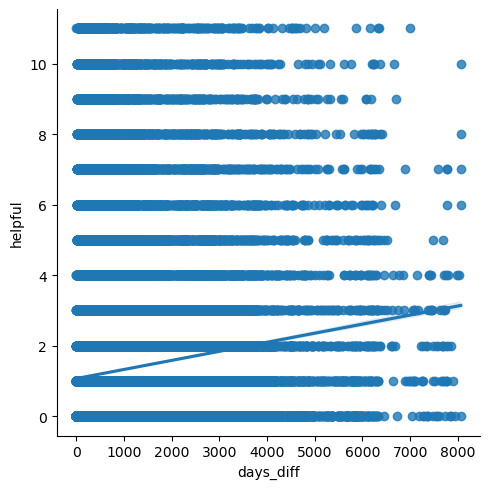

In [4]:
#plot days_diff versus helpful with a smooth line
sns.lmplot(x = 'days_diff', y = 'helpful', data = df)

In [84]:
df['days_diff'].describe()

count    114978.000000
mean        659.717416
std         962.037709
min           0.000000
25%          80.000000
50%         253.000000
75%         821.000000
max        8060.000000
Name: days_diff, dtype: float64

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor


vectorizer = CountVectorizer(max_features = 1000)

In [33]:
df[df['review_clean'].isna()][['review_clean', 'review']]

,review_clean,review
375,NaN,A
1056,NaN,A
1772,NaN,So so
2263,NaN,A+
2316,NaN,It does what it should.
...,...,...
116980,NaN,A+
118027,NaN,Above
118701,NaN,A+
121122,NaN,on


In [107]:
#split data
df = df.dropna(subset = ['review_clean'])

In [108]:
#remove outliers with percentile
df = df[df['helpful'] < df['helpful'].quantile(0.95)]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df['review_clean'], df['helpful'], test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#fit vectorizer
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [75]:
from sklearn.feature_selection import SelectKBest, f_regression

# Initialize SelectKBest with f_regression
kbest = SelectKBest(f_regression, k=1000)

# Perform feature selection
X_train_k = kbest.fit_transform(X_train, y_train)
X_val_k = kbest.transform(X_val)
X_test_k = kbest.transform(X_test)

In [76]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_k, y_train)

KNeighborsRegressor()

In [77]:
y_pred = knn.predict(X_val_k)

In [78]:
#mse
mse = (y_pred - y_val)**2

In [79]:
#get top 10 largest values in mse
mse.nlargest(10)

36565     121.0
27614     121.0
61719     121.0
88488     121.0
19467     121.0
49100     121.0
30591     121.0
100877    121.0
64625     121.0
71384     121.0
Name: helpful, dtype: float64

In [80]:
np.mean(mse)

4.917543849476705

In [72]:
#do a grid search
from sklearn.neighbors import KNeighborsRegressor

#results df
#results = pd.DataFrame(columns = ['k', 'mse'])
for k in range(15, 25, 2):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    print(k, np.mean((y_pred - y_val)**2))
    results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)

15 4.880813433965668


C:\Users\janva\AppData\Local\Temp\ipykernel_13108\282051470.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)


17 4.875604467964364


C:\Users\janva\AppData\Local\Temp\ipykernel_13108\282051470.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)


19 4.872842641081859


C:\Users\janva\AppData\Local\Temp\ipykernel_13108\282051470.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)


21 4.874354670404387


C:\Users\janva\AppData\Local\Temp\ipykernel_13108\282051470.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)


23 4.877224917885589


C:\Users\janva\AppData\Local\Temp\ipykernel_13108\282051470.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'mse': np.mean((y_pred - y_val)**2)}, ignore_index = True)


In [74]:
#sve
results.to_csv('../../gen/output/amazon_knn_results.csv', index = False)

# Picture cleaning

In [3]:
df = pd.read_csv('../../gen/output/amazon_search_hedonic_clean_merged.csv', sep = ";")

In [ ]:
cp_photos = pd.read_csv('../../gen/input/amazon_photos.csv', sep = ";")